<a href="https://colab.research.google.com/github/radanim/TIL/blob/master/07_stock_price_RNN_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNN 으로 주가예측하기

In [23]:
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

## 주가수집

In [25]:
# 삼성전자 주가 수집
df = fdr.DataReader("005930","2020")
df.shape

(686, 6)

In [26]:
df.head(20)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921
2020-01-09,58400,58600,57400,58600,24102579,0.031690
2020-01-10,58800,59700,58300,59500,16000170,0.015358
2020-01-13,59600,60000,59100,60000,11359139,0.008403
2020-01-14,60400,61000,59900,60000,16906295,0.000000


In [27]:
df.tail(2)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-10-11,54400,55700,54000,55400,21437877,-0.014235
2022-10-12,55700,57000,55200,55900,9695421,0.009025


## 문제, 답안 나누기

In [28]:
df_ohlcv = df.iloc[:, :-1] # 마지막 컬럼 제외하고 저장

dfx = df_ohlcv.drop(columns ="Close")
dfy = df_ohlcv["Close"]
dfx.shape # 정답(Y) -- close, 훈련(x) - close제외한 나머지

(686, 4)

## 정규화 

In [29]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
# 복원을 위해 x, y 따로 스케일링하기
# 스케일링 후 list 형태로 변환하기
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()
x = mmsx.fit_transform(dfx).tolist()
y = mmsy.fit_transform(dfy.to_frame()).tolist()

In [30]:
len(x[0]), len(y[0])
# (685, 4)      (685, 1)

(4, 1)

## x, y 값 window_size 적용하기


<center>
<img src = "https://i.stack.imgur.com/padg4.gif">
</center>
* 이미지출처: https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn


In [31]:
window_size = 10 
len(y) - window_size

676

In [32]:
# window_size 만큼만 슬라이싱
# 10일치 데이터로 다음날 주가를 예측
# 다음 날 종가(i+windows_size)는 포함되지 않도록 X값을 만들고
# 다음 날 종가를 y로 만듦
window_size = 10 
x_data = []
y_data = []

for i in range(len(y) - window_size):
    _x = x[i : i+window_size]
    _y = y[i + window_size]
    x_data.append(_x)
    y_data.append(_y)

In [33]:
len(x_data), len(y_data)

(676, 676)

## train, test 나누기

In [34]:
# 8:2 로 나누기
split_size = int(len(x_data) * 0.8)
split_size

540

In [35]:
X_train = np.array(x_data[:split_size]) # 80
y_train = np.array(y_data[:split_size]) #80
X_test = np.array(x_data[split_size:]) # 20
y_test = np.array(y_data[split_size:]) #20

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((540, 10, 4), (540, 1), (136, 10, 4), (136, 1))

## 모델 생성

In [37]:
data_size = dfx.shape[1]
data_size

4

In [38]:
# 모델 생성

data_size = dfx.shape[1]

model = Sequential()
model.add(LSTM(units=10, activation='relu', return_sequences=True,input_shape=(window_size, data_size)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=10, activation='relu')))
model.add(Dropout(0.1))
model.add(Dense(units=1)) # 분류를 하기 위한 학습
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 10)            600       
                                                                 
 dropout_2 (Dropout)         (None, 10, 10)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               1680      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
____________________________________________________

## compile

In [39]:
model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse', 'mae']) # 회귀 (y^ - y)^2 // 분류 categorical entropy

## 학습과 예측

In [40]:
X_train.shape, y_train.shape

((540, 10, 4), (540, 1))

In [41]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, batch_size=30, verbose=1)
# early stopping기능 추가하기. invalid syntax

Epoch 1/100
15/15 [==============================] - 3s 32ms/step - loss: 0.2906 - mse: 0.2906 - mae: 0.4770 - val_loss: 0.3181 - val_mse: 0.3181 - val_mae: 0.5606
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 0.2098 - mse: 0.2098 - mae: 0.3991 - val_loss: 0.1745 - val_mse: 0.1745 - val_mae: 0.4146
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0702 - mse: 0.0702 - mae: 0.1975 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0718
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.1185 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1337
Epoch 5/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0921 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0355
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0858 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0523
Epoch 7/100
15/15 [==

In [42]:
# y_pred
df_hist = pd.DataFrame(history.history)

In [43]:
df_hist

,loss,mse,mae,val_loss,val_mse,val_mae
0,0.290595,0.290595,0.477040,0.318088,0.318088,0.560628
1,0.209758,0.209758,0.399102,0.174499,0.174499,0.414565
2,0.070154,0.070154,0.197488,0.009254,0.009254,0.071776
3,0.027496,0.027496,0.118476,0.019534,0.019534,0.133702
4,0.017359,0.017359,0.092078,0.002082,0.002082,0.035482
...,...,...,...,...,...,...
95,0.005596,0.005596,0.056815,0.001765,0.001765,0.031518
96,0.005200,0.005200,0.054852,0.001612,0.001612,0.034735
97,0.005747,0.005747,0.055715,0.003567,0.003567,0.051934
98,0.006044,0.006044,0.060211,0.002187,0.002187,0.040632


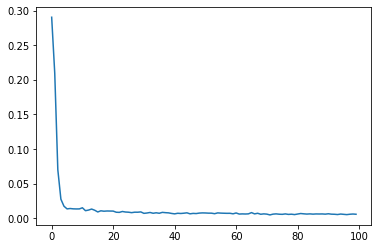

In [44]:
df_hist['loss'].plot()

In [45]:
y_pred = model.predict(X_test)

In [46]:
# rmse
np.sqrt(np.square(y_test - y_pred).mean())

0.03824563196928527

## 예측 결과 시각화

In [47]:
y_test.shape, y_pred.shape

((136, 1), (136, 1))

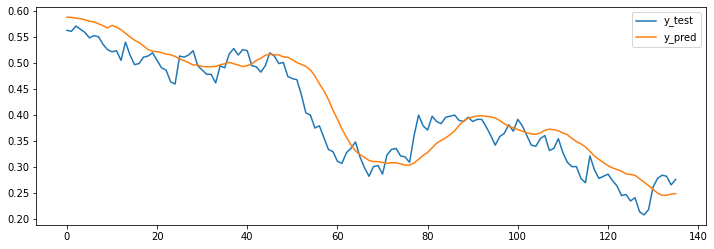

In [48]:
plt.figure(figsize= (12, 4))
plt.plot(y_test.flatten(), label='y_test')
plt.plot(y_pred.flatten(), label='y_pred')
plt.legend()

## 원래 값으로 복원하여 비교

In [49]:
y_predict_inverse = mmsy.inverse_transform(y_pred)
y_predict_inverse[:5]

array([[71016.51 ],
       [71009.305],
       [70929.44 ],
       [70882.34 ],
       [70776.625]], dtype=float32)

In [50]:
y_test_inverse = mmsy.inverse_transform(y_test)
y_test_inverse[:5
]

array([[69800.],
       [69700.],
       [70200.],
       [69900.],
       [69600.]])

In [51]:
# rmse 
np.sqrt(np.square(y_test_inverse-y_predict_inverse).mean())

1854.9138361040905

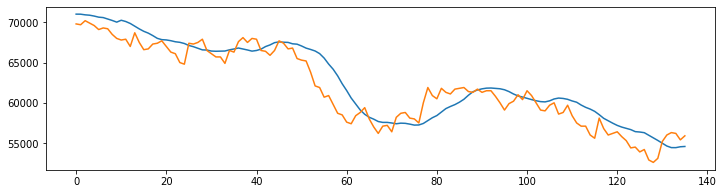

In [52]:
# 시각화
plt.figure(figsize = (12, 3))
plt.plot(y_predict_inverse)
plt.plot(y_test_inverse)